**Andres Varela**



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional,SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import re
from keras.models import load_model
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#Emotion Text Prediction

The purpose of this work is to develop models using NLP, capable to classify text input into emotion class based on LSTM and Transformers Architectures to compare its performance on both scenario. The dataset used to test this models contains 20K phrase labeled by emotion:Joy, Anger, Sadness, Fear, Love and suprise.

Our first Task consist in data pre-processing accessing each sentence removing duplicated data and special characters (data cleaning). Once our data is ready to work with, we can proceed with the tokenizing and sequence task in order to convert all the data to numerical representation, which can be feeded to our models for training and testing purposes.

Our first approach is going to be made building an LSTM network, and then two Transformers architecture to test performance

[Emotions Dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data)

In [ ]:
#Loading Dataset
df_train = pd.read_csv('/content/drive/MyDrive/datossec/emotions/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/datossec/emotions/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/datossec/emotions/test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
#Joinign al dataset for pre-processing
data=pd.concat([df_train , df_val , df_test ])

In [ ]:
#exploring dataset
data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
#our data has 20k inputs divided by sentence and emotion
data.shape

(20000, 2)

In [ ]:
#view sentiment distribution by # sentences
sentiment = data['Emotion'].value_counts()
sentiment

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotion, dtype: int64

In [ ]:
# search for duplicate data and drop it
duplicates=data.duplicated(subset=['Text'])
duplicates = duplicates.sum()
print(f"duplciated data: {duplicates} ")

data=data.drop_duplicates(subset=['Text'])
sentiment = data['Emotion'].value_counts()
sentiment

duplciated data: 52 


joy         6739
sadness     5793
anger       2703
fear        2369
love        1630
surprise     714
Name: Emotion, dtype: int64

In [ ]:
#NLTK stopwords provides a bag of words called stopwpords which do not provide meaningful info
#about text context

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#cleaning data removing stop words and special characters
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Text'] = data['Text'].apply(clean_text)
data['Text'] = data['Text'].str.replace('\d+', '')


<ipython-input-11-9228e00f19ea>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Text'] = data['Text'].str.replace('\d+', '')


In [ ]:
#visualizing cleaned data
data

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
1995,keep feeling like someone unkind wrong think g...,anger
1996,im feeling little cranky negative doctors appo...,anger
1997,feel useful people gives great feeling achieve...,joy
1998,im feeling comfortable derby feel though start...,joy


In [ ]:
#tokenizing dictionary

# The maximum number of words to be used.
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# Embedding dimension
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16908 unique tokens.


In [ ]:
#tokenizing to sequence
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (19948, 250)


In [ ]:
# converting labels to sparse categorical
Y = pd.get_dummies(data['Emotion']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (19948, 6)


In [ ]:
#coding sparse label to one hot categorical
onehot=pd.DataFrame(Y)
labels=data.Emotion.to_numpy()
labels=labels.reshape(-1,1)
print(onehot.shape,labels.shape)

(19948, 6) (19948, 1)


In [ ]:
coded=np.hstack((onehot, labels))
coded=pd.DataFrame(coded)
coded

,0,1,2,3,4,5,6
0,0,0,0,0,1,0,sadness
1,0,0,0,0,1,0,sadness
2,1,0,0,0,0,0,anger
3,0,0,0,1,0,0,love
4,1,0,0,0,0,0,anger
...,...,...,...,...,...,...,...
19943,1,0,0,0,0,0,anger
19944,1,0,0,0,0,0,anger
19945,0,0,1,0,0,0,joy
19946,0,0,1,0,0,0,joy


In [ ]:
#visualizing one hot coded labels
coded = coded.drop_duplicates()
nan_count = coded.isna().sum().sum()
print(nan_count)
coded


0


,0,1,2,3,4,5,6
0,0,0,0,0,1,0,sadness
2,1,0,0,0,0,0,anger
3,0,0,0,1,0,0,love
6,0,0,0,0,0,1,surprise
7,0,1,0,0,0,0,fear
8,0,0,1,0,0,0,joy


In [ ]:
emotions=['anger','fear','joy','love','sadness','surprise']

In [ ]:
#splitting dataset
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size = 0.20, random_state = 42)

In [ ]:
print(X_train.shape,Y_train.shape)

print(X_test.shape,Y_test.shape)

(15958, 250) (15958, 6)
(3990, 250) (3990, 6)


##Emotion Predcition with LSTM

Here we are making our first approach using LSTM unit and a final dense layer with 6 neurones to fit to our encoded label

In [ ]:
#build LSTM model using embedding layer and 6 neuron dense layer for classification
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5081006 (19.38 MB)
Trainable params: 5081006 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### LSTM Parameter Calculation:

## Embedding Layer:

$Embedding=InputDim\ast OutputDim=50.0000*100=5'000.000$
$Embedding=MaxNWords\ast EmbbedingDim=50.0000*100=5'000.000$

## LSTM_1:

$LSTM1=4\left [ (input+ output) \ast output+bias \right ]$

$LSTM1=4\left [ (100+100) \ast100+100 \right ]=80400$

##Dense_1:


$Dense1=input \ast output + bias $

$Dense1=100\ast 6 + 6=606 $


In [ ]:
#training LSTM
start=time.time()
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end=time.time()
print(f'Elapsed time: {(end-start) * 10**3} ms')

Epoch 1/5
225/225 [==============================] - 319s 1s/step - loss: 1.3015 - accuracy: 0.5101 - val_loss: 0.6553 - val_accuracy: 0.8001
Epoch 2/5
225/225 [==============================] - 295s 1s/step - loss: 0.3293 - accuracy: 0.8951 - val_loss: 0.2745 - val_accuracy: 0.9035
Epoch 3/5
225/225 [==============================] - 296s 1s/step - loss: 0.1228 - accuracy: 0.9581 - val_loss: 0.2386 - val_accuracy: 0.9167
Epoch 4/5
225/225 [==============================] - 334s 1s/step - loss: 0.0706 - accuracy: 0.9762 - val_loss: 0.2715 - val_accuracy: 0.9110
Epoch 5/5
225/225 [==============================] - 330s 1s/step - loss: 0.0461 - accuracy: 0.9844 - val_loss: 0.2706 - val_accuracy: 0.9217
Elapsed time: 1585240.658044815 ms


Elapsed time while training: 26minutes

In [ ]:
elapsedtime=((end-start) * 10**3)/60000
elapsedtime

26.420677634080253

Saving our model and its weights to avoid re-training for testing purposes

In [ ]:
#saving model and weights
model.save('lstm.h5')
model.save_weights('lstm_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#evaluate the model
model.evaluate(X_test,Y_test)

125/125 [==============================] - 11s 83ms/step - loss: 0.2663 - accuracy: 0.9233


[0.2662799060344696, 0.923308253288269]

###TESTING

In [ ]:
#loading model and its wheights
model=load_model('/content/lstm.h5')
model.load_weights('/content/drive/MyDrive/datossec/lstm_weights.h5')

In [ ]:
#preparing text into sequence to be interpretable by model
def text_preparation(string):
  text=clean_text(string)
  text=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=MAX_SEQUENCE_LENGTH)
  return text


In [ ]:
text=text_preparation('im not okay, im afraid i will be late')

In [ ]:
predict=model.predict(text)

1/1 [==============================] - 0s 116ms/step


In [ ]:
#predicting emotion
print(f'te predicted emotion is: {emotions[np.argmax(predict)]}')

te predicted emotion is: fear


##Emotion Prediction with Transformers

Our second approach using Transformer unit

In [ ]:
from tensorflow import keras
from keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,use_bias=True
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    #x = layers.Dense(inputs.shape[-1], kernel_size=1)(x)
    x = layers.Dense(256)(x)
    return x + res

In [ ]:
max_tokens=20000
def build_model(
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    dropout=0,
    mlp_dropout=0,
):
    #inputs = keras.Input(shape=input_shape)
    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = embedded
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(6,activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
#input_shape = XtrainE.shape[1:]
modeloT = build_model(
    head_size=128,
    num_heads=2,
    ff_dim=128,
    num_transformer_blocks=1,
    dropout=0.25,
    mlp_dropout=0.5,
)


modeloT.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

modeloT.summary()


Exception ignored in: <function _xla_gc_callback at 0x7ab7f8308d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, None, 256)            5120000   ['input_4[0][0]']             
                                                                                                  
 layer_normalization_6 (Lay  (None, None, 256)            512       ['embedding_4[0][0]']         
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_3 (Mu  (None, None, 256)            263168    ['layer_normalization_6[

# Transformer 1 Parameters Calculation

## Embediing Layer:

$Embedding=InputDim\ast OutputDim$

$Embedding=MaxNTokens\ast EmbbedingDim=20.0000*256=5'120.000$

## Layer Normalization 10:

$LN10=Input\ast InputDim =256\ast2=512$

## MultiHead Attn_5:

$MH5= 4\left [ Dmodel \right ]\ast headsize\ast NoHeads+bias$

$bias=3*(headsize*2)+Dmodel$

$MH5= 4\left [ 256 \right ]\ast 128\ast 2+bias$

$bias=3*(256)+256=1024$

$MH5= 4\left [ 256 \right ]\ast 128\ast 2+1024 =263168$

## Dense_16:


$Dense16=input \ast output + bias $

$Dense16=256\ast 128 + 128=32892 $

## Dense_17:


$Dense17=input \ast output + bias $

$Dense17=128\ast 256 + 256=33024 $

## Dense_18:


$Dense18=input \ast output + bias $

$Dense18=256\ast 6 + 6=1524 $

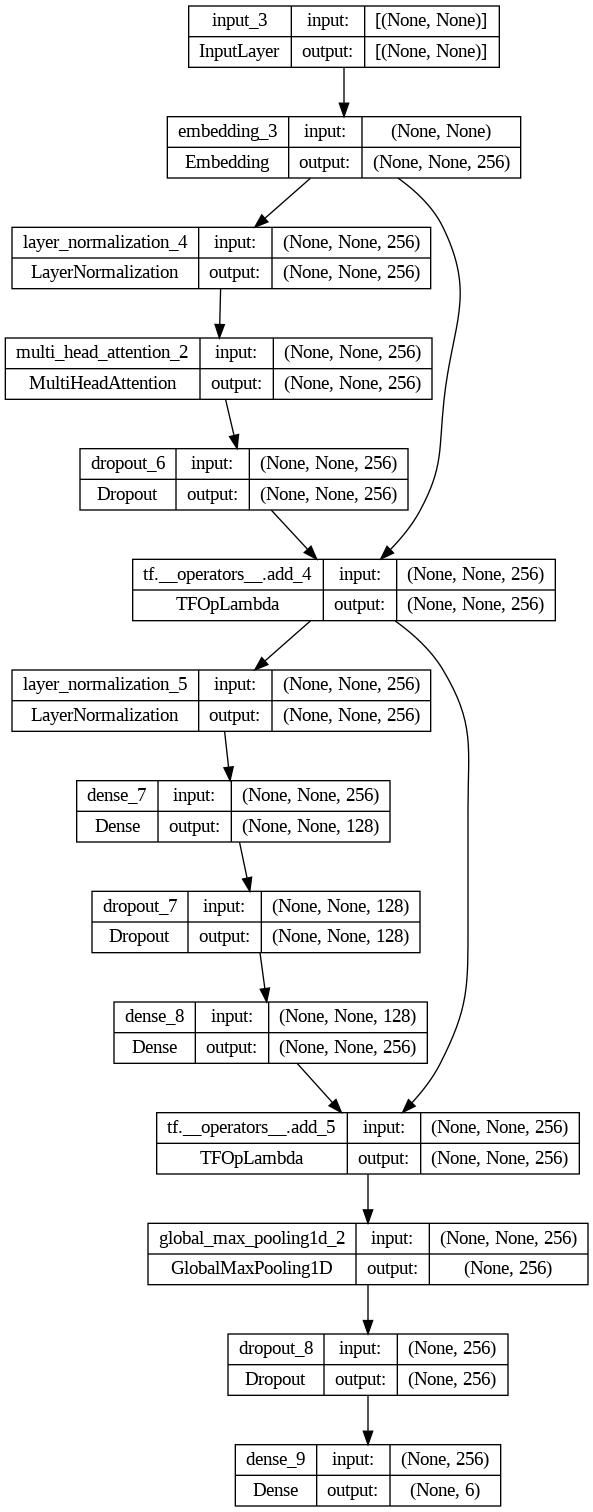

In [ ]:
tf.keras.utils.plot_model(modeloT, to_file='transformer1.png', show_shapes=True)

In [ ]:
start=time.time()
epochs = 10
batch_size = 64

history = modeloT.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])
#print(f"Test acc: {modelo.evaluate(int_test_ds)[1]:.3f}")
end=time.time()
print(f'Elapsed time: {(end-start) * 10**3} ms')

Epoch 1/10
225/225 [==============================] - 27s 93ms/step - loss: 1.3077 - accuracy: 0.5517 - val_loss: 0.6237 - val_accuracy: 0.8089
Epoch 2/10
225/225 [==============================] - 13s 56ms/step - loss: 0.4920 - accuracy: 0.8471 - val_loss: 0.4166 - val_accuracy: 0.8684
Epoch 3/10
225/225 [==============================] - 10s 46ms/step - loss: 0.3501 - accuracy: 0.8920 - val_loss: 0.4116 - val_accuracy: 0.8709
Epoch 4/10
225/225 [==============================] - 10s 44ms/step - loss: 0.2775 - accuracy: 0.9093 - val_loss: 0.3844 - val_accuracy: 0.8722
Epoch 5/10
225/225 [==============================] - 10s 43ms/step - loss: 0.2523 - accuracy: 0.9167 - val_loss: 0.4429 - val_accuracy: 0.8603
Epoch 6/10
225/225 [==============================] - 11s 47ms/step - loss: 0.2148 - accuracy: 0.9270 - val_loss: 0.4657 - val_accuracy: 0.8553
Epoch 7/10
225/225 [==============================] - 10s 47ms/step - loss: 0.1979 - accuracy: 0.9335 - val_loss: 0.4948 - val_accuracy:

Elapsed time while training: 1,6min

In [ ]:
elapsedtime=((end-start) * 10**3)/60000
elapsedtime

1.6689819733301798

In [ ]:
modeloT.save('transformer.h5')
modeloT.save_weights('transformer_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modeloT.evaluate(X_test,Y_test)

125/125 [==============================] - 1s 11ms/step - loss: 0.6000 - accuracy: 0.8323


[0.6000226736068726, 0.8323308229446411]

##Testing

In [ ]:
modeloT=load_model('/content/transformer.h5')
modeloT.load_weights('/content/transformer_weights.h5')

In [ ]:
def text_preparation(string):
  text=clean_text(string)
  text=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=MAX_SEQUENCE_LENGTH)
  return text

In [ ]:
text=text_preparation('im not okay, im afraid i will be late')

In [ ]:
predict=modeloT.predict(text)

1/1 [==============================] - 0s 20ms/step


In [ ]:
print(f'te predicted emotion is: {emotions[np.argmax(predict)]}')

te predicted emotion is: fear


#Transformers Model2

Third approach using transformer unit with positional embedding (keras official page tutorial)

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)#multihead layer
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),] #feedforward hidden layer
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)#normalization
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)#normalization
        self.dropout1 = layers.Dropout(rate)#Dropout
        self.dropout2 = layers.Dropout(rate)#Droput

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)#token embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)#positional embedding layer

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each sentence


In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(6, activation="softmax")(x)

modeloT2 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
modeloT2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
modeloT2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250)]             0         
                                                                 
 token_and_position_embeddi  (None, 250, 32)           648000    
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_2 (Trans  (None, 250, 32)           10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_22 (Dropout)        (None, 32)                0   

#Tansformer 2 Parameters Calculation

##Token and Position Embedding Layer:

$TokenAndPositionEmbedding=TokenEmbedding + PositionEmbedding $

$TokenEmbedding=InputDim\ast OutputDim=VocabSize\ast EmbDim$

$PositionEmbedding=InputDim\ast OutputDim=MaxLen\ast EmbDim$

$TokenAndPositionEmbedding=(20000 \ast 32) + (256 \ast 32) = 648.000$

##Transformer Block:

###MultiHead Attn_22:

$MH22= 4\left [ Dmodel \right ]\ast headsize\ast NoHeads+bias$

$bias=3*(headsize*2)+Dmodel$

$MH22= 4\left [ 32 \right ]\ast 32\ast 2+bias$

$bias=3*(32*2)+32=224$

$MH22= 4\left [ 32 \right ]\ast 32\ast 2+224 =8416$

### Layer_norm18

$layernorm18=dmodel*Dim=32*2=64$

### Sequential

$Sequential=2*Dense(34)=2*(in*out+bias)=2*(32*32+32)=2112$

### Layer_norm19

$layernorm18=dmodel*Dim=32*2=64$


### Transformer_block Total:

$Transformer_block= 8416 + 64 + 2112 + 64 = 10656$



##Dense_25:


$Dense25=input \ast output + bias $

$Dense25=32\ast 20 + 20= 660 $

## Dense_26:


$Dense26=input \ast output + bias $

$Dense26=20\ast 6 + 6=126 $



Whole Network Architecture

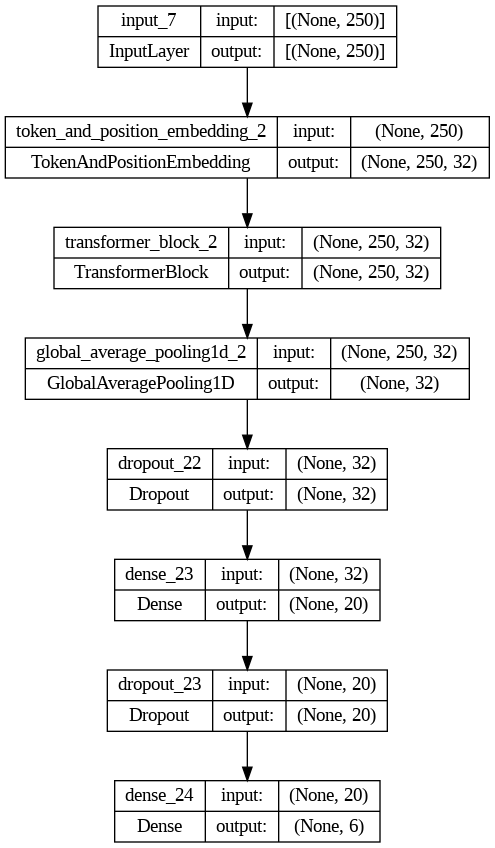

In [ ]:
tf.keras.utils.plot_model(modeloT2, to_file='Tranformer2.png', show_shapes=True)

###Exploring in deep Transformer Block Architecture

In [ ]:
from tensorflow import keras
from keras import layers, Sequential

TransformerB=Sequential()
ffn= keras.Sequential([layers.Dense(32, activation="relu"), layers.Dense(32),])
inputs = keras.Input(shape=(None,32), dtype="float32")
x=layers.MultiHeadAttention(num_heads=2,key_dim=32)(inputs,inputs)
x = layers.Dropout(0.1)(x)
x= layers.LayerNormalization(epsilon=1e-6)(x+inputs)
out1=ffn(x)
x= ffn(x)

x=layers.Dropout(0.1)(x)
output= layers.LayerNormalization(epsilon=1e-6)(out1+x)

TransformerB=keras.Model(inputs,output)


In [ ]:
TransformerB.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 32)]           0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, None, 32)             8416      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, None, 32)             0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, None, 32)             0         ['dropout[0][0]',         

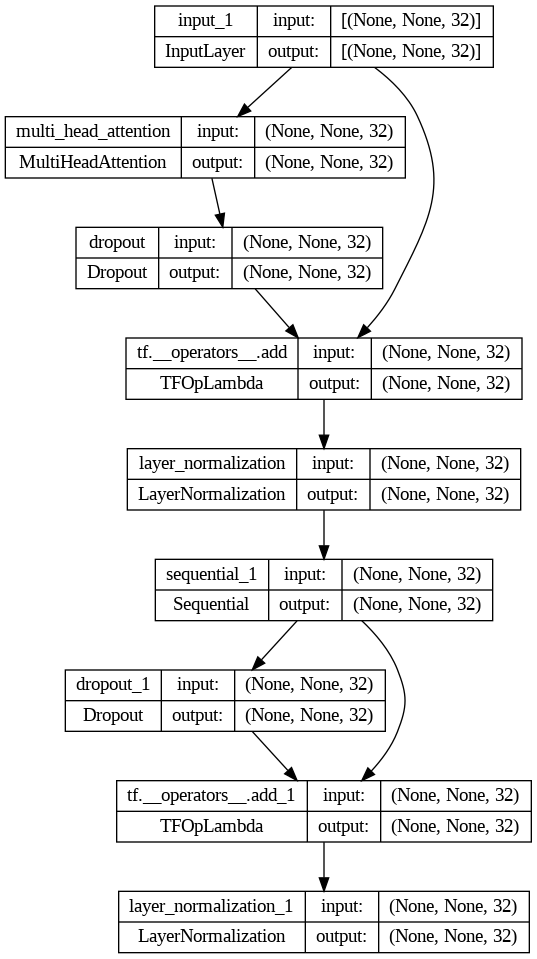

In [ ]:
tf.keras.utils.plot_model(TransformerB, to_file='Transformerblock.png', show_shapes=True)

###Training Whole Architechture

In [ ]:
start=time.time()
history = modeloT2.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.1)
end=time.time()
print(f'Elapsed time: {(end-start) * 10**3} ms')

Epoch 1/5
449/449 [==============================] - 21s 40ms/step - loss: 1.6025 - accuracy: 0.3283 - val_loss: 1.5902 - val_accuracy: 0.3302
Epoch 2/5
449/449 [==============================] - 7s 15ms/step - loss: 1.1349 - accuracy: 0.5361 - val_loss: 0.4557 - val_accuracy: 0.8678
Epoch 3/5
449/449 [==============================] - 6s 14ms/step - loss: 0.3522 - accuracy: 0.8930 - val_loss: 0.2815 - val_accuracy: 0.9004
Epoch 4/5
449/449 [==============================] - 5s 11ms/step - loss: 0.2232 - accuracy: 0.9261 - val_loss: 0.2730 - val_accuracy: 0.9016
Epoch 5/5
449/449 [==============================] - 6s 14ms/step - loss: 0.1671 - accuracy: 0.9427 - val_loss: 0.3106 - val_accuracy: 0.8935
Elapsed time: 83908.48517417908 ms


Elapsed Time while training : 1,39m

In [ ]:
elapsedtime=((end-start) * 10**3)/60000
elapsedtime

1.3984747529029846

In [ ]:
modeloT2.save('transformerkeras.h5')
modeloT2.save_weights('transformerkeras_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
modeloT2.evaluate(X_test,Y_test)

125/125 [==============================] - 2s 13ms/step - loss: 0.3139 - accuracy: 0.8965


[0.31389161944389343, 0.8964912295341492]

##TESTING

In [ ]:
modeloT2=load_model('/content/transformerkeras.h5')
modeloT2.load_weights('/content/transformerkeras_weights.h5')

In [ ]:
def text_preparation(string):
  text=clean_text(string)
  text=pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=MAX_SEQUENCE_LENGTH)
  return text

In [ ]:
text=text_preparation('im not okay, im afraid i will be late')

In [ ]:
predict=modeloT2.predict(text)

1/1 [==============================] - 0s 35ms/step


In [ ]:
print(f'te predicted emotion is: {emotions[np.argmax(predict)]}')

te predicted emotion is: fear


#Overview and Conclusions

| Network      | T.Time | Epochs | Loss | ACC  | # Params  |
|--------------|--------|--------|------|------|-----------|
| LSTM         | 26min  | 5      | 0.26 | 0.92 | 5.081.006 |
| Transformer1 | 1,6    | 10     | 0.6  | 0.83 | 5.451.654 |
| Transformer2 | 1.39   | 5      | 0.31 | 0.89 | 659.442   |



*   Pre-processing data stage it's crucial for NLP purpose, because cleaning data before embedding will allow us to perform coding text to its purest form of representation, using NLTK stop words and dropping special characters will do the task for this exercise, but if you are going to work with another kind of dataset which uses special characters for context (like tweets or mentions in social media) can change the way that the machine interpreatates the sentences. Analyze the purpose of your specific task to take this kind of decissions.
*   LSTM network led us to abetter result in terms of accuracy and loss, but it has more computational cost compared with transformer architecture for this specific solution. It is imperative to know the nature of the data, because LSTM in such point will lead to gradient vanishing for very long sentences or corpus, but this was not the case, each sentence had a maximun of 40 words which is suitable for NLP with LSTM

*   Transformers based architectures can perfom better in this scenario in terms of time and computational cost, making things easier for fine tunning or for architecture fixing, because it needs less training time you can edit the network while you are looking for your desired outcome. for this case with the same or more number of epochs in less time we get a way looking similar performance in terms of loss and accuracy.Exploring the way we tuned the network and the architecture itself its proven that it can be adjusted for better performance.

*  With the second transformer architecture which incorporates spatial embedding and the way that its layer are connected togheter we can achieve better performance than the other architectures, for future works we can explore if increasing atention heads, changing embedding dimenssion or even more transformer blocks we can improve the performarce or even fine tunning parameters.

